<a href="https://colab.research.google.com/github/abhijitnayak8/abhijitnayak8/blob/main/FruitToEmoji_GIT_modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://www.arduino.cc/"><img src="https://raw.githubusercontent.com/sandeepmistry/aimldevfest-workshop-2019/master/images/Arduino_logo_R_highquality.png" width=200/></a>
# Tiny ML on Arduino
## Classify objects by color tutorial

 
https://github.com/arduino/ArduinoTensorFlowLiteTutorials/

## Setup Python Environment 

The next cell sets up the dependencies in required for the notebook, run it.

In [ ]:
# Setup environment
# !apt-get -qq install xxd
!sudo apt-get update -y
!sudo apt-get install -y xxd
!pip install pandas numpy matplotlib
%tensorflow_version 2.x
!pip install tensorflow

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:10 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:11 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [80.4 kB]
Get:12 http://archive.ubuntu.com/ubun

# Upload Data

1. Open the panel on the left side of Colab by clicking on the __>__
1. Select the Files tab
1. Drag `csv` files from your computer to the tab to upload them into colab.

In [ ]:
!pwd

/content


# Train Neural Network





## Parse and prepare the data

The next cell parses the csv files and transforms them to a format that will be used to train the full connected neural network.



TensorFlow version = 2.8.0

nano class will be output 0 of the classifier
173 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



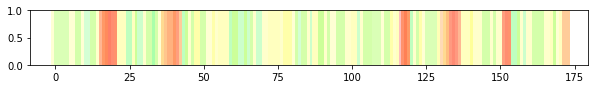

peipa class will be output 1 of the classifier
256 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



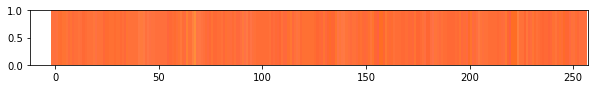

rpi class will be output 2 of the classifier
210 samples captured for training with inputs ['Red', 'Green', 'Blue'] 



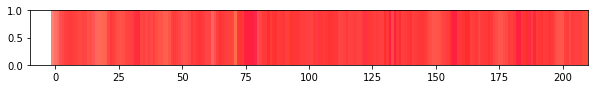

Data set parsing and preparation complete.
Data set randomization and splitting complete.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import fileinput

print(f"TensorFlow version = {tf.__version__}\n")

# Set a fixed random seed value, for reproducibility, this will allow us to get
# the same random numbers each time the notebook is run
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

CLASSES = [];

for file in os.listdir("/content/"):
    if file.endswith(".csv"):
        CLASSES.append(os.path.splitext(file)[0])

CLASSES.sort()

SAMPLES_WINDOW_LEN = 1
NUM_CLASSES = len(CLASSES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_CLASSES = np.eye(NUM_CLASSES)

inputs = []
outputs = []

# read each csv file and push an input and output
for class_index in range(NUM_CLASSES):
  objectClass = CLASSES[class_index]
  df = pd.read_csv("/content/" + objectClass + ".csv")
  columns = list(df)
  # get rid of pesky empty value lines of csv which cause NaN inputs to TensorFlow
  df = df.dropna()
  df = df.reset_index(drop=True)
   
  # calculate the number of objectClass recordings in the file
  num_recordings = int(df.shape[0] / SAMPLES_WINDOW_LEN)
  print(f"\u001b[32;4m{objectClass}\u001b[0m class will be output \u001b[32m{class_index}\u001b[0m of the classifier")
  print(f"{num_recordings} samples captured for training with inputs {list(df)} \n")

  # graphing
  plt.rcParams["figure.figsize"] = (10,1)
  pixels = np.array([df['Red'],df['Green'],df['Blue']],float)
  pixels = np.transpose(pixels)
  for i in range(num_recordings):
    plt.axvline(x=i, linewidth=8, color=tuple(pixels[i]/np.max(pixels[i], axis=0)))
  plt.show()
  
  #tensors
  output = ONE_HOT_ENCODED_CLASSES[class_index]
  for i in range(num_recordings):
    tensor = []
    row = []
    for c in columns:
      row.append(df[c][i])
    tensor += row
    inputs.append(tensor)
    outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")


## Build & Train the Model

Build and train a [TensorFlow](https://www.tensorflow.org) model using the high-level [Keras](https://www.tensorflow.org/guide/keras) API.

In [ ]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(8, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(5, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')) # softmax is used, because we only expect one class to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=400, batch_size=4, validation_data=(inputs_validate, outputs_validate))



Epoch 1/400
96/96 [==============================] - 1s 3ms/step - loss: 0.2117 - mae: 0.4314 - val_loss: 0.2076 - val_mae: 0.4271
Epoch 2/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2071 - mae: 0.4260 - val_loss: 0.2022 - val_mae: 0.4207
Epoch 3/400
96/96 [==============================] - 0s 2ms/step - loss: 0.2005 - mae: 0.4187 - val_loss: 0.1942 - val_mae: 0.4113
Epoch 4/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1905 - mae: 0.4071 - val_loss: 0.1824 - val_mae: 0.3977
Epoch 5/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1769 - mae: 0.3900 - val_loss: 0.1690 - val_mae: 0.3796
Epoch 6/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1640 - mae: 0.3718 - val_loss: 0.1569 - val_mae: 0.3607
Epoch 7/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1525 - mae: 0.3530 - val_loss: 0.1467 - val_mae: 0.3426
Epoch 8/400
96/96 [==============================] - 0s 2ms/step - loss: 0.1424 - m

### Run with Test Data
Put our test data into the model and plot the predictions


In [ ]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
# print("predictions =\n", np.round(predictions, decimals=3)[50])
print("predictions =\n", predictions[50])
print("actual =\n", outputs_test[50])

correct_count = 0

for i in range(len(predictions)):
  label = np.argmax(predictions[i])
  if outputs_test[i][label] == 1:
    correct_count += 1

print(correct_count)
print(correct_count/len(outputs_test))


# # Plot the predictions along with to the test data
# plt.clf()
# plt.title('Training data predicted vs actual values')
# plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
# plt.plot(inputs_test, predictions, 'r.', label='Predicted')
# plt.show()

predictions =
 [9.9999261e-01 7.3389624e-06 6.0341992e-16]
actual =
 [1. 0. 0.]
121
0.952755905511811


# Convert the Trained Model to Tensor Flow Lite

The next cell converts the model to TFlite format. The size in bytes of the model is also printed out.

In [ ]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)
  
  

INFO:tensorflow:Assets written to: /tmp/tmpycqftii1/assets


Model is 2204 bytes


## Encode the Model in an Arduino Header File 

The next cell creates a constant byte array that contains the TFlite model. Import it as a tab with the sketch below.

In [ ]:
!echo "const unsigned char model[] = {" > /content/model.h
!cat gesture_model.tflite | xxd -i      >> /content/model.h
!echo "};"                              >> /content/model.h

import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")
print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 13,626 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.


# Realtime Classification of Sensor Data on Arduino

Now it's time to switch back to the tutorial instructions and run our new model on the [Arduino Nano 33 BLE Sense](https://www.arduino.cc/en/Guide/NANO33BLE)